In [10]:
%pylab inline

import copy
import argparse
import numpy as np
import lsst.daf.persistence   as dafPersist
import lsst.afw.coord         as afwCoord
import lsst.afw.image         as afwImage
import lsst.afw.geom          as afwGeom
import lsst.afw.table         as afwTable

# Matplotlib default settings
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 10
mpl.rcParams['xtick.major.size'] = 8.0
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 8.0
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4.0
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rc('axes', linewidth=2)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_20141224/'
filter  = 'HSC-I'

## Get cutout image

In [4]:
# Get the skymap 
butler = dafPersist.Butler(rootDir)
skyMap = butler.get("deepCoadd_skyMap", immediate=True)

In [379]:
# Example galaxy: 
# From redmapper ID=16474; z=0.38
wideRa  = 133.02153
wideDec = 1.3656108
sizeCut = 2000    # Extreme
sizeExp = (sizeCut * 2 + 1) ** 2

In [380]:
def getCircleRaDec(ra, dec, size):

    # Get a small but representative set of (RA, DEC) that describe a circle
    # region around the central input coordinate

    # Convert the size from pixel unit to degress
    sizeDegree = (size * 0.168) / 3600.0
    # representative set of polar angles
    angles = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
    phi = np.array(angles * np.pi / 180.0)
    
    # Get the (Ra, Dec) coordinates of these points 
    raList  = ra  + sizeDegree * np.cos(phi)
    decList = dec + sizeDegree * np.sin(phi)
    
    # Also include the center 
    raList  = np.append(raList,  ra)
    decList = np.append(decList, dec)

    return raList, decList

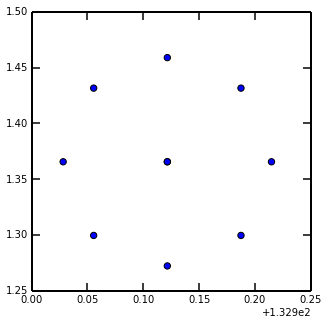

In [381]:
raList, decList = getCircleRaDec(wideRa, wideDec, sizeCut)

fig = plt.figure(figsize=[5,5])
ax  = plt.gca()

ax.scatter(wideRa, wideDec, s=40.0, c='r')
ax.scatter(raList, decList, s=40.0, c='b')

In [382]:
# Try list match 
points = map(lambda x, y: afwGeom.Point2D(x, y), raList, decList)
coord = map(lambda x: afwCoord.IcrsCoord(x), points)
matches = skyMap.findClosestTractPatchList(coord)
# Number of matched Tracts 
nTract = len(matches)

In [384]:
# Number of matched Patches 
nPatch = 0 
for tt in np.arange(nTract): 
    nPatch += len(matches[tt][1])
print nPatch

4


In [385]:
for tract, patch in matches: 
    tractId = tract.getId() 
    patchId = "%d,%d" % patch[0].getIndex()
    print "Find (Tract, Patch): %d, %s" % (tractId, patchId)

Find (Tract, Patch): 9559, 5,7


In [386]:
coadd = butler.get("deepCoadd", tract=tractId, patch=patchId, filter='HSC-I', immediate=True)

In [387]:
wcs = coadd.getWcs()
center = afwCoord.IcrsCoord(afwGeom.Point2D(wideRa, wideDec))

In [388]:
pixel = wcs.skyToPixel(center)
pixel = afwGeom.Point2I(pixel)

In [389]:
bbox = afwGeom.Box2I(pixel, pixel)
bbox.grow(sizeCut)
bbox.clip(coadd.getBBox(afwImage.PARENT))

In [390]:
subImage = afwImage.ExposureF(coadd, bbox, afwImage.PARENT).getMaskedImage().getArrays()

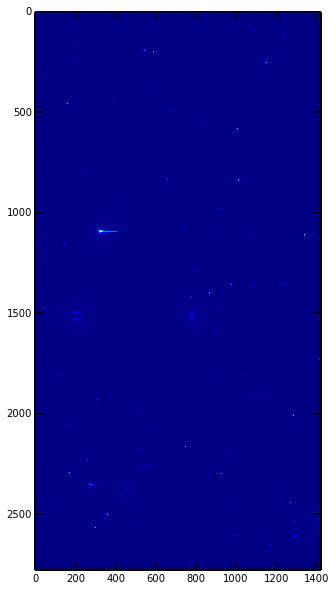

In [393]:
plt.imshow(subImage[0])
#plt.scatter(pixel.getX(), pixel.getY(), s=40, c='w', alpha=0.6)

## Make a RGB color image

In [415]:
import lsst.afw.display.rgb as afwRgb

images = {}
wcs    = {}
filters = ['HSC-G', 'HSC-R', 'HSC-I']

for i in [0,1,2]: 
    
    exp = butler.get('deepCoadd', immediate=True, tract=tractId, 
                    patch=patchId, filter=filters[i])
    expWcs = exp.getWcs()
    
    sub = afwImage.ExposureF(exp, bbox, afwImage.PARENT)
    subWcs = sub.getWcs()
    
    images[i] = sub
    wcs[i] = subWcs 

In [419]:
# 
raDec = afwCoord.Coord(wideRa*afwGeom.degrees, wideDec*afwGeom.degrees)

B = images[0].getMaskedImage().getImage() 
G = images[1].getMaskedImage().getImage()
R = images[2].getMaskedImage().getImage() 

cenB = wcs[0].skyToPixel(raDec)
print cenB
cenG = wcs[1].skyToPixel(raDec)
cenR = wcs[2].skyToPixel(raDec)

xy0B = B.getXY0()
print xy0B

(24679, 31324)
(22679, 29324)


In [417]:
cenBImg = (cenB[0] - xy0B[0], cenB[1] - xy0B[1])
print cenBImg

(2000.0615726919605, 2000.4380743518195)


In [427]:
B.

(-27323, -1.0)

In [414]:
bBox.getBegin()

Point2I(0, 0)

In [397]:
min = 0.001
max = 0.8
range = (max - min)
Q = 6
imgRgb = afwRgb.makeRGB(R, G, B, min=min, range=range, Q=Q, saturatedPixelValue=None)

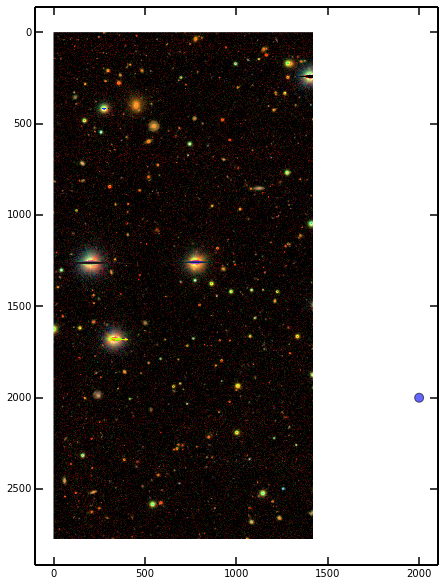

In [401]:
plt.imshow(imgRgb, interpolation='none')
plt.scatter(cenB[1] - xy0B[1], cenB[0] - xy0B[0], s=80, c='b',
           alpha=0.6)

In [362]:
def isHscFilter(filter, full=True):

    if full:
        hscFilters = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']
    else:
        hscFilters = ['g', 'r', 'i', 'z', 'y']

    return (filter in hscFilters)

filt = ['HSC-G', 'HSC-R', 'HSC-I'] 

if len(filt) is not 3:
    raise Exception("Have to be three filters!")
elif not (isHscFilter(filt[0]) & isHscFilter(filt[1]) &
          isHscFilter(filt[2])):
    raise Exception("Not all filters are valid !")
else: 
    print "Ok!"

Ok!


In [367]:
print B.getXY0()
print cenB

(24479, 31124)
(24679, 31324)


## Find all objects around the cutout center using the source catalog

In [289]:
cat = butler.get('deepCoadd_forced_src', tract=tractId, patch=patchId, 
                 filter=filter, immediate=True)

In [290]:
srcRa  = np.array(map(lambda x: x.get('coord').getRa().asDegrees(),  cat))
srcDec = np.array(map(lambda x: x.get('coord').getDec().asDegrees(), cat))

In [262]:
sizeDeg = (200.0 * 0.168 / 3600.0)

In [310]:
indMatch = ((srcRa > (wideRa - sizeDeg)) & (srcRa < (wideRa + sizeDeg)) & 
            (srcDec > (wideDec - sizeDeg)) & (srcDec < (wideDec + sizeDeg)))

/home/song/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/home/song/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from IPython.kernel.zmq import kernelapp as app


In [311]:
indMatch

array([False, False, False, ..., False, False, False], dtype=bool)

In [312]:
subCat = cat.subset(indMatch)

In [313]:
len(subCat)

350

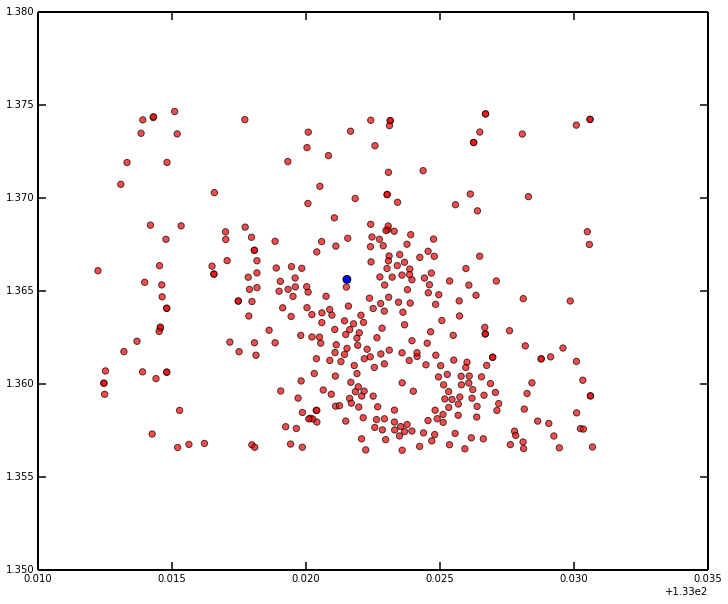

In [314]:
plt.scatter(srcRa[indMatch], srcDec[indMatch], s=40, c='r', alpha=0.7)
plt.scatter(wideRa, wideDec, s=60, c='b')